### Finding a good measure of candy desirability

- **winpercent**: how often was this candy the preterred choice in 1v1s
  - But: Candy sizing and price weren't fair, it's reasonable to assume that some wins were due to:
    - more quality bias (I'd rather win a Ferrari than a Golf, but I'd rather buy a golf than a ferrari)
    - more quantiY bias (I prefer snickers over a kitkat, but as a greedy kid I'd have chosen the kitkat if it was clearly bigger)

Thus we want to include **pricepercent** to metigate these biases. Thus we for a desirability metric we will use **weighted geometric mean**, since both metrics are ordered, and their relationship is likely multiplicative (i.e., a candy that scores well in both dimensions should be highly desirable):


$$\text{Weighted Geometric Mean} = \text{pricepercent}^{w_{price}} \times \text{winpercent}^{1-w_{price}}$$


In [1]:
from data_processing import CandyDataProcessor
processor = CandyDataProcessor(file_path = 'candy-data.csv', price_percent_weight=0.2)

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

X, y = processor.prepare_features_and_target(
    feature_columns=processor.get_predictor_cols(),
    target_column='desirability'
)
X = sm.add_constant(X)

# Step 3: Fit the linear regression model using statsmodels
model = sm.OLS(y, X)
result = model.fit()

# Step 4: Print the summary of the model
print(result.summary())
_ = processor.reset()

                            OLS Regression Results                            
Dep. Variable:           desirability   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     10.80
Date:                Sat, 24 Aug 2024   Prob (F-statistic):           1.44e-10
Time:                        12:03:16   Log-Likelihood:                 39.314
No. Observations:                  85   AIC:                            -58.63
Df Residuals:                      75   BIC:                            -34.20
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1940      0.061  

In [2]:
from statsmodels.formula.api import glm

X, y = processor.prepare_features_and_target(
    feature_columns=processor.get_predictor_cols(),
    target_column='desirability'
)

model = glm("y ~ " + " + ".join(X.columns), data=pd.concat([X, y], axis=1), family=sm.families.Binomial()).fit()

# Step 4: Print the summary of the model
print(model.summary())
_ = processor.reset()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   85
Model:                            GLM   Df Residuals:                       75
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.893
Date:                Sat, 24 Aug 2024   Deviance:                       9.8377
Time:                        12:03:16   Pearson chi2:                     8.81
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1190
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.4001      0.877  

<Axes: >

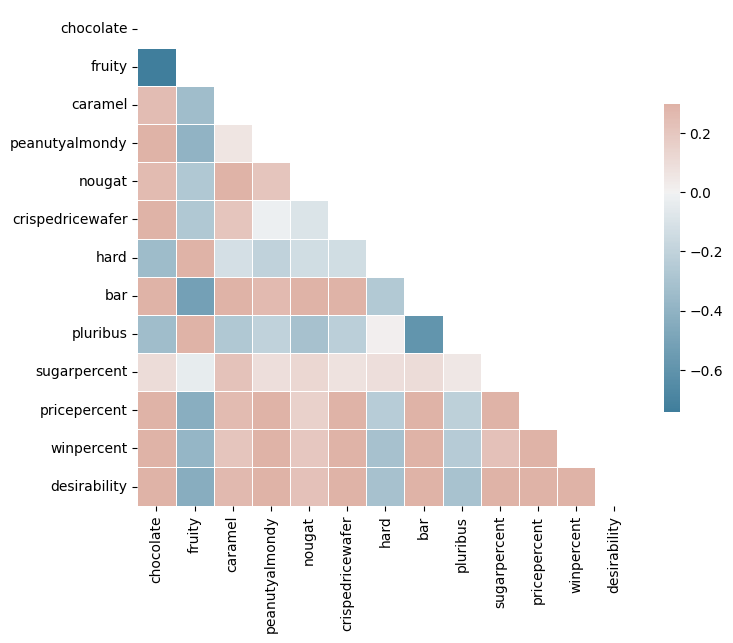

In [3]:
_ = processor.reset()
corr = processor.df.iloc[:, 1:].corr() #correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool)) # mask for upper triangle
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Interaction Effects

Just checking some interaction effects

In [4]:
# Prepare features and target
_ = processor.reset()
X, y = processor.prepare_features_and_target(
    feature_columns=processor.get_predictor_cols(),
    target_column='desirability'
)

# Create interaction terms based on correlation insights
interaction_terms = [('fruity', 'chocolate')]

# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
X = X.copy()

# Add interaction terms to the feature set
for col1, col2 in interaction_terms:
    interaction_col_name = f"{col1}:{col2}"
    X[interaction_col_name] = X[col1] * X[col2]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model to examine interaction effects
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.561521
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           desirability   No. Observations:                   85
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                           10
Date:                Sat, 24 Aug 2024   Pseudo R-squ.:                  0.1396
Time:                        12:03:16   Log-Likelihood:                -47.729
converged:                       True   LL-Null:                       -55.474
Covariance Type:            nonrobust   LLR p-value:                    0.1152
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.4587      0.903     -1.616      0.106      -3.228       0.310
chocolate  

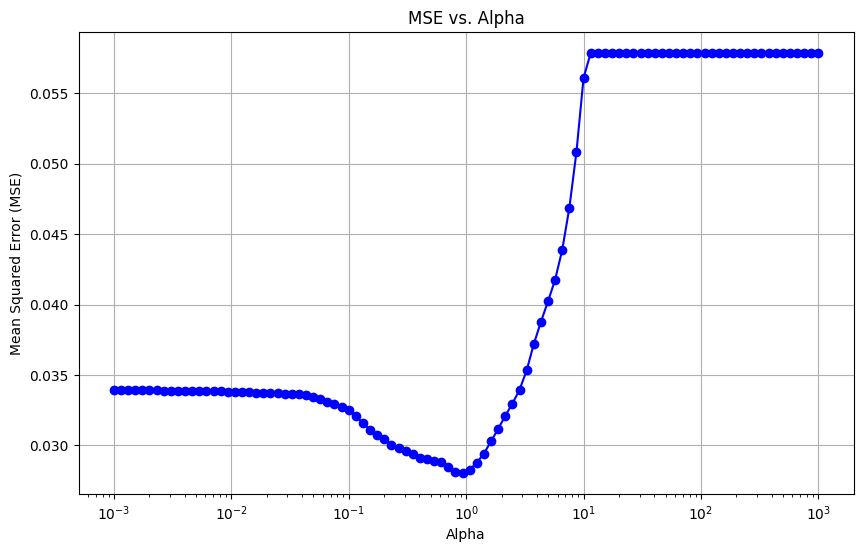

The alpha-MSE pair with the lowest MSE is: (np.float64(0.9326033468832199), np.float64(0.02803172037947014))


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Reset the processor and prepare data
_ = processor.reset()
X, y = processor.prepare_features_and_target(
    feature_columns=processor.get_predictor_cols(),
    target_column='desirability'
)
X_scaled = scaler.fit_transform(X)

# Create interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_scaled)

# Create DataFrame for better understanding
interaction_features = poly.get_feature_names_out(X.columns)
X_interactions_df = pd.DataFrame(X_interactions, columns=interaction_features)

def perform_cv(alpha:float, kf) -> float:
    """ Performs CV for a reg. param alpha and returns the avg. MSE"""
    # Initialize lists for cross-validation scores
    mse_scores = []
    
    # Perform cross-validation
    for train_index, test_index in kf.split(X_interactions_df):
        X_train, X_test = X_interactions_df.iloc[train_index], X_interactions_df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Add constant (intercept) term to the features
        X_train = sm.add_constant(X_train, has_constant='add')
        X_test = sm.add_constant(X_test, has_constant='add')

        model = sm.Logit(y_train, X_train)
        result = model.fit_regularized(method='l1_cvxopt_cp', alpha=alpha, disp=0)  # Adjust alpha as needed

        # Predict and evaluate on the test set
        predictions = result.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)
     
    return np.mean(mse_scores)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
alpha_score_list = []

# Run CV for different alphas
for alpha in np.logspace(-3, 3, 100):
    mse = perform_cv(alpha, kf)
    alpha_score_list.append((alpha, mse))

alphas = [pair[0] for pair in alpha_score_list]
mses = [pair[1] for pair in alpha_score_list]

# Plot the MSE vs. Alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, mses, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha')
plt.grid(True)
plt.show()

# Find the alpha, mse pair with the lowest mse
min_mse_pair = min(alpha_score_list, key=lambda x: x[1])
print(f"The alpha-MSE pair with the lowest MSE is: {min_mse_pair}")

In [10]:
# Redo Regression with found alpha for inference

_ = processor.reset()
X, y = processor.prepare_features_and_target(
    feature_columns=processor.get_predictor_cols(),
    target_column='desirability'
)

# Create interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_scaled)

# Create DataFrame for better understanding
interaction_features = poly.get_feature_names_out(X.columns)
X_interactions_df = pd.DataFrame(X_interactions, columns=interaction_features)

X_interactions_df = sm.add_constant(X_interactions_df, has_constant='add')
model = sm.Logit(y, X_interactions_df)
result = model.fit_regularized(method='l1_cvxopt_cp', alpha=0.7054802310718645, disp=0)  # Adjust alpha as needed

# Predict and evaluate on the test set
predictions = result.predict(X_interactions_df)
mse = mean_squared_error(y, predictions)

from io import StringIO
def clean_summary(summary):
    
    summary_html = summary.tables[1].as_html()  # Table with coefficients and statistics
    df = pd.read_html(StringIO(summary_html), header=0, index_col=0)[0]
    
    # Drop rows and columns where all elements are NaN
    df_cleaned = df.dropna(how='any').dropna(axis=1, how='any')
    df_rounded = df_cleaned.round(4)
    
    return df_rounded

cleaned_summary = clean_summary(result.summary())
display(cleaned_summary.sort_values(by='P>|z|'))
print(f"Mean Squared Error (MSE): {mse}")


,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.4105,0.319,-1.288,0.198,-1.035,0.214
chocolate,0.4571,0.369,1.238,0.216,-0.267,1.181
chocolate peanutyalmondy,0.2526,0.454,0.556,0.578,-0.638,1.143
chocolate caramel,0.1470,0.329,0.446,0.655,-0.499,0.793
fruity pluribus,0.1284,0.300,0.428,0.669,-0.459,0.716
peanutyalmondy bar,-0.1149,0.299,-0.384,0.701,-0.702,0.472
peanutyalmondy caramel,-0.1211,0.454,-0.267,0.790,-1.010,0.768
bar,0.0846,0.385,0.219,0.826,-0.671,0.840
crispedricewafer,0.1001,0.471,0.213,0.832,-0.822,1.022
nougat peanutyalmondy,0.0675,0.354,0.191,0.849,-0.627,0.762


Mean Squared Error (MSE): 0.01809465225140955


In [7]:
import pandas as pd
import numpy as np
import itertools

def get_nonzero_coefficients(result):
    """ Extract non-zero coefficients from the fitted model """
    coefficients = result.params
    # Consider a coefficient non-zero if its absolute value is greater than a very small threshold
    non_zero_coefficients = coefficients[coefficients.abs() > 1e-10]
    return non_zero_coefficients

# Get non-zero coefficients
non_zero_coefficients = get_nonzero_coefficients(result)

# Prepare features
features = list(non_zero_coefficients.index)
main_features = processor.get_predictor_cols()
interaction_features = [feat for feat in features if ' ' in feat]

# Generate all possible combinations for main features (0 or 1)
all_combinations = list(itertools.product([0, 1], repeat=len(main_features)))
candy_combinations = pd.DataFrame(all_combinations, columns=main_features)

def compute_logit_score(row, coefficients):
    logit_score = 0
    # Check for intercept term
    intercept = coefficients.get('const', 0)  # Default to 0 if 'const' is not in coefficients
    logit_score += intercept
    
    for feature, coef in coefficients.items():
        if feature == 'const':
            continue  # Skip intercept term which is already added
        if ' ' not in feature:  # Single feature
            if row.get(feature, 0) == 1:
                logit_score += coef
        else:  # Interaction term
            f1, f2 = feature.split(' ')
            if row.get(f1, 0) == 1 and row.get(f2, 0) == 1:
                logit_score += coef
    return logit_score

# Calculate logit score
candy_combinations['logit_score'] = candy_combinations.apply(
    lambda row: compute_logit_score(row, non_zero_coefficients),
    axis=1
)

# Transform logit to probability (using logistic function)
candy_combinations['probability'] = 1 / (1 + np.exp(-candy_combinations['logit_score']))

# Rank the combinations based on the probability
ranked_candies = candy_combinations.sort_values(by='probability', ascending=False)

# Display top N combinations
top_n = 10
display(ranked_candies.head(top_n))

,chocolate,fruity,hard,nougat,crispedricewafer,peanutyalmondy,caramel,bar,pluribus,logit_score,probability
447,1,1,0,1,1,1,1,1,1,0.619051,0.650003
445,1,1,0,1,1,1,1,0,1,0.611160,0.648205
443,1,1,0,1,1,1,0,1,1,0.593207,0.644101
511,1,1,1,1,1,1,1,1,1,0.585657,0.642368
441,1,1,0,1,1,1,0,0,1,0.585316,0.642290
509,1,1,1,1,1,1,1,0,1,0.577766,0.640553
429,1,1,0,1,0,1,1,0,1,0.561061,0.636698
507,1,1,1,1,1,1,0,1,1,0.559813,0.636409
505,1,1,1,1,1,1,0,0,1,0.551922,0.634581
415,1,1,0,0,1,1,1,1,1,0.551503,0.634484


ToDo: Incorporate Price (less price better, since bias towards more)
todo: do not select too many features

In [ ]:
Best/Worst features + best/worst interactions